In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import sys
import urllib3
import json
import operator
import collections

import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Edit the following to configure the notebook

In [2]:
'''Edit Below'''

gene = "PTEN" #The gene you want to examine

number_of_interacting_proteins_to_examine = 30 #The number of interacting proteins you want to look at

hotspot = True #(True or False) Whether you want to examine the effect of hotspot mutations in this gene

proteomics = True #(True or False) Whether you want to see results of proteomic data

phosphoproteomics  = True #(True or False) Whether you want to see results of phosphoproteomic data

transcriptomics = True #(True or False) Whether you want to see results of transcriptomic data

subtype = True #(True or False) Whether you want to examine impact of subtype

dataset = 'Endometrial' #options are Endometrial, Ovarian, etc.

## Get the dataframes

In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

## General gene statistics

In [4]:
'''Get the hotspot3D output '''
hotspot_data = pd.ExcelFile('../HotSpot3D_Output/HotSpot3DOutput.xlsx')

'''Get the sheet name called Clusters to find the protein hotspot'''
clusters = hotspot_data.parse('Clusters')


try:
    '''Check if the gene of interest has a hotspot'''
    hotspot_areas = clusters.loc[clusters['Gene/Drug'] == gene]
    hotspot_mutations = hotspot_areas['Mutation/Gene']
    hotspot_mutations = hotspot_mutations.tolist()

    '''A list of mutations present in the hotspot according to our Hotspot3D output'''
    mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
    hotspot_patients = mutated_hotspot['Clinical_Patient_Key']
    print('Patients with hotspot mutations: \n')
    print(hotspot_patients)
    
except:
    print('{}' '{}'.format(gene, ' does not have a hotspot in our data.'))
    hotspot = False

Patients with hotspot mutations: 

Series([], Name: Clinical_Patient_Key, dtype: object)


## Mutation frequency

Total number of patients with PTEN mutations: 75
Total number of PTEN mutation instances: 126

                   Mutation Count
Missense_Mutation              60
Nonsense_Mutation              27
Frame_Shift_Del                26
Frame_Shift_Ins                11
Splice_Site                     2


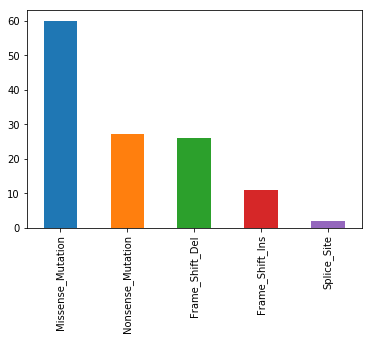

In [5]:
gene_mutated = somatic.loc[somatic['Gene'] == gene]

'''Select from the dataframe all patients with a Mutation in the gene'''
genedf = CPTAC.compare_mutations(proteomics, gene, gene)
mutdf = genedf.loc[genedf['Sample_Status'] == 'Tumor']
mutdf = mutdf.loc[genedf[gene+"_Mutation"] != 'Wildtype_Tumor']

'''See how many patients have a mutation in the given gene'''
num_mutated = len(mutdf)

print('{}' '{}' '{}' '{}' .format('Total number of patients with ' , gene, ' mutations: ', num_mutated))
total_mutations = len(gene_mutated)
print('{}' '{}' '{}' '{}' '{}'.format('Total number of ' , gene, ' mutation instances: ', total_mutations, '\n'))

'''Count the number of instances of various mutation types in the column 'Mutation' in the gene_mutated dataframe.'''

mut_counts = gene_mutated['Mutation'].value_counts()

'''The previous function returns a series. Convert the series to a dataframe'''
counts_df = mut_counts.to_frame()

'''Rename the column to clarify the number of mutations'''
counts_df = counts_df.rename(index=str, columns = { 'Mutation' : 'Mutation Count'})
print(counts_df)

'''Plot the frequencies'''
mut_counts.plot.bar()
plt.show()

## Access STRING database to compile list of interacting proteins

In [6]:
'''Use urllib3 to access the string database api, gather list of interacting proteins'''
urllib3.disable_warnings()
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "network"

'''Use the specified gene and homo sapiens species code'''
my_gene = [gene]
species = "9606"

'''Format the api request to collect the appropriate information'''
request_url = string_api_url + "/" + output_format + "/" + method + "?"
request_url += "identifiers=%s" % "%0d".join(my_gene)
request_url += "&" + "species=" + species
request_url += "&" + "limit=" + str(number_of_interacting_proteins_to_examine)

'''Send a request to the API, print the response status'''
try:
    http = urllib3.PoolManager()
    response = http.request('GET',request_url)
    print("Accessing String database, response status: ", response.status)
except urllib3.HTTPError as err:
    error_message = err.read()
    print(error_message)
    sys.exit()

interacting_proteins = []
if response.status == 200: 
    '''Get the data from the API's response'''
    data = response.data
    y = json.loads(data)

    '''Make a list of the resulting interacting proteins'''
    for entry in y:
        if entry["preferredName_A"] not in interacting_proteins:
            interacting_proteins.append(entry["preferredName_A"])
        if entry["preferredName_B"] not in interacting_proteins:
            interacting_proteins.append(entry["preferredName_B"])

    print("\nTop " + str(number_of_interacting_proteins_to_examine) + " " + gene + " interacting proteins: \n")
    for ip in interacting_proteins:
        print(ip)
else:
    print("\nSpecified gene was not found in String database, double check that you have it correctly!")
    interacting_proteins.append(gene)

Accessing String database, response status:  200

Top 30 PTEN interacting proteins: 

MDM2
CSNK2A1
STUB1
PDGFRB
PIK3R2
PIK3C3
CSNK2A2
SLC9A3R1
PIK3R3
USP13
PIK3CA
TP53
EGFR
PIK3CB
INPPL1
PTK2
USP7
WWP2
XIAP
PTEN
PREX2
MAST2
OTUD3
PIK3CD
ROCK1
SHC1
ITPKB
NEDD4
INPP4B
PIK3R1
AKT1


## Examine proteomic levels of interacting protiens

In [7]:
'''Use list of interacting proteins as our protein list'''
protein_list = interacting_proteins

p_values = {}
'''Loop through every protein in the list'''
for protein in protein_list:
    if protein in proteomics.columns:
        '''Use CPTAC compare_mutations to compare proteomic levels when gene is mutated'''
        protdf = CPTAC.compare_mutations(proteomics, protein, gene)
        '''Look only at Tumor types'''
        protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
        '''Split into mutated and wildtype dataframes'''
        mutateddf = protdf.loc[protdf[gene+"_Mutation"] != 'Wildtype_Tumor']
        wildtypedf = protdf.loc[protdf[gene+"_Mutation"] == 'Wildtype_Tumor']
        '''Do a t-test to compare the mutated and wildtype groups, see if they show a significant difference'''
        ttest, p_val = scipy.stats.ttest_ind(mutateddf[protein+"_omics"], wildtypedf[protein+"_omics"])
        '''Store protein and p-value in a dictionary, if it is a real value'''
        if not np.isnan(p_val):
            p_values[protein] = p_val
    else:
        print("Gene ", protein, " not found in proteomics data!")
        
'''Display all the interacting proteins and their p-value'''
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in p_values.items()) + "\n}")

Gene  MDM2  not found in proteomics data!
Gene  PIK3R3  not found in proteomics data!
{
CSNK2A1: 0.00010182893922667103
STUB1: 0.7688260272337302
PDGFRB: 0.8693006301586769
PIK3R2: 0.44088927883323115
PIK3C3: 0.1290854275324418
CSNK2A2: 0.014752092665294259
SLC9A3R1: 0.08419773959278688
USP13: 0.7667678275385694
PIK3CA: 1.7218712565199584e-05
EGFR: 0.019946236243029075
PIK3CB: 0.5105884699891937
INPPL1: 0.2744160500389567
PTK2: 0.3687574051092677
USP7: 0.9779029273680782
WWP2: 0.6100397917506133
XIAP: 0.6220891738696203
PTEN: 0.018255212674572408
PREX2: 0.005154583868362958
MAST2: 0.6629514959450722
PIK3CD: 0.20369543277540533
ROCK1: 0.5423524341693947
SHC1: 0.02589373326159397
ITPKB: 0.5438176841669873
NEDD4: 0.33812372411552083
INPP4B: 0.2557066785395606
PIK3R1: 0.10643037944987976
AKT1: 0.6245628256682187
}


## Adjust for multiple testing with a Bonferroni correction

In [8]:
alpha = .05
bonferroni_adjusted_cutoff = alpha/len(p_values)
print('Bonferroni Corrected P-Value Cutoff: {0:10.7f}'.format(bonferroni_adjusted_cutoff))

Bonferroni Corrected P-Value Cutoff:  0.0018519


## Determine which interacting proteins' proteomic abundance are significantly different when gene is mutated

In [9]:
significant_interacting_proteins = {}
unsignificant_interacting_proteins = {}
for key, val in p_values.items():
    if val <= bonferroni_adjusted_cutoff:
        significant_interacting_proteins[key] = val
    else:
        unsignificant_interacting_proteins[key] = val

print("Significant values: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in significant_interacting_proteins.items()) + "\n}")

print("\nInsignificant values: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in unsignificant_interacting_proteins.items()) + "\n}")

Significant values: 
{
CSNK2A1: 0.00010182893922667103
PIK3CA: 1.7218712565199584e-05
}

Insignificant values: 
{
STUB1: 0.7688260272337302
PDGFRB: 0.8693006301586769
PIK3R2: 0.44088927883323115
PIK3C3: 0.1290854275324418
CSNK2A2: 0.014752092665294259
SLC9A3R1: 0.08419773959278688
USP13: 0.7667678275385694
EGFR: 0.019946236243029075
PIK3CB: 0.5105884699891937
INPPL1: 0.2744160500389567
PTK2: 0.3687574051092677
USP7: 0.9779029273680782
WWP2: 0.6100397917506133
XIAP: 0.6220891738696203
PTEN: 0.018255212674572408
PREX2: 0.005154583868362958
MAST2: 0.6629514959450722
PIK3CD: 0.20369543277540533
ROCK1: 0.5423524341693947
SHC1: 0.02589373326159397
ITPKB: 0.5438176841669873
NEDD4: 0.33812372411552083
INPP4B: 0.2557066785395606
PIK3R1: 0.10643037944987976
AKT1: 0.6245628256682187
}


## Make a plot showing proteomic difference for most significant protein

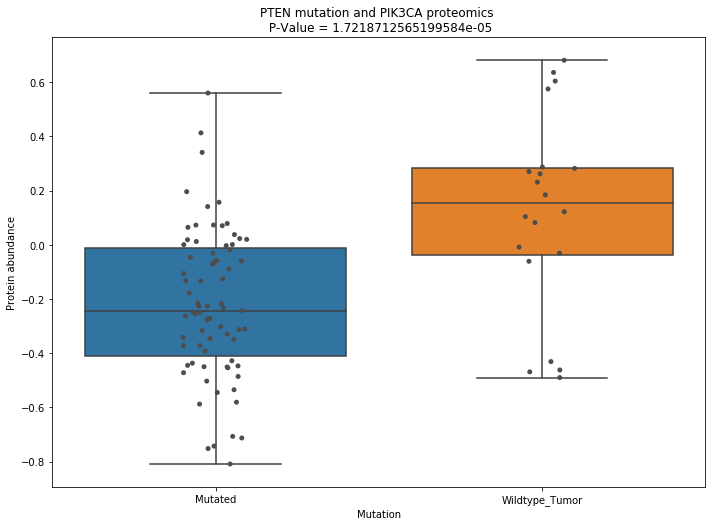

In [11]:
'''Sort p-value dictionary to order most significant p-values first'''
sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))
#print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in sorted_dict.items()) + "\n}")

'''Get the most significant protein'''
most_significant_protein = (next(iter(sorted_dict)))
p_value_of_most_significant = p_values[most_significant_protein]
'''Get dataframe comparing protein abundance with gene mutation'''
most_sig_df = CPTAC.compare_mutations(proteomics, most_significant_protein, gene)
'''Select only tumor type'''
most_sig_df = most_sig_df.loc[most_sig_df['Sample_Status'] == 'Tumor']

'''Classify all mutations as "mutated" for the plot'''
for i, row in most_sig_df.iterrows():
    if row[gene + '_Mutation'] != 'Wildtype_Tumor':
        most_sig_df.at[i,gene+'_Mutation'] = 'Mutated'


'''Generate the plot'''
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=most_sig_df, x=gene+"_Mutation",y=most_significant_protein+"_omics")
phos_boxplot.set_title(gene + " mutation and " + most_significant_protein + " proteomics \n P-Value = " + str(p_value_of_most_significant))
phos_boxplot = sns.stripplot(data=most_sig_df, x=gene+"_Mutation", y=most_significant_protein+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Protein abundance")
plt.show()